# iNaturalist 2019
### **Transfer learning from pretrained model using Keras**

As part of the FGVC6 workshop at CVPR 2019, Kaggle is conducting the iNat Challenge 2019, the large scale species classification competition, sponsored by Microsoft. It is estimated that the natural world contains several million species of plants and animals. Without expert knowledge, many of these species are extremely difficult to accurately classify due to their visual similarity. The goal of this competition is to push the state of the art in automatic image classification for real world data that features a large number of fine-grained categories.

This Kernel will use the idea of "Transfer Learning", various pre-trained model will be used be used for the problem of multiclassification.

### Librairies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import gc # garbage collector
import cv2
import tensorflow as tf
from keras.models import load_model
from keras.models import Sequential
from keras.applications import MobileNetV2
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers
from keras.callbacks import ModelCheckpoint

### Train dataframe

In [2]:
# make train_anns dict based on the json file
train_anns_file = 'data/input/train2019.json' 
with open(train_anns_file) as data:
        train_anns = json.load(data) 

In [3]:
# select only [image_id] and [category_id]
train_anns_df = pd.DataFrame(train_anns['annotations'])[['image_id','category_id']] 

# select only [id] and [filename] then rename [id] to [image_id]
train_img_df  = pd.DataFrame(train_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'}) 

# merge two dataframes on [image_id] 
df_train_file_cat = pd.merge(train_img_df, train_anns_df, on='image_id') 
df_train_file_cat['category_id']=df_train_file_cat['category_id'].astype(str)

df_train_file_cat.head()

,image_id,file_name,category_id
0,0,train_val2019/Plants/400/d1322d13ccd856eb4236c...,400
1,1,train_val2019/Plants/570/15edbc1e2ef000d8ace48...,570
2,2,train_val2019/Reptiles/167/c87a32e8927cbf4f06d...,167
3,3,train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...,254
4,4,train_val2019/Plants/739/ffa06f951e99de9d220ae...,739


In [4]:
print(len(df_train_file_cat['category_id'].unique()), "classes found in the dataset")

1010 classes found in the dataset


### Validation dataframe

In [5]:
# dict based on the json file
valid_anns_file = 'data/input/val2019.json'
with open(valid_anns_file) as data:
        valid_anns = json.load(data)

In [6]:
# validation dataframe -> use after test inference to check the accuracy

valid_anns_df = pd.DataFrame(valid_anns['annotations'])[['image_id','category_id']] 
valid_anns_df.head() 

,image_id,category_id
0,265213,644
1,265214,597
2,265215,883
3,265216,300
4,265217,881


In [7]:
# validation input dataframe -> use after training

# select only [id] and [filename] then rename [id] to [image_id]
valid_img_df = pd.DataFrame(valid_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'}) 
valid_img_df.head()

,image_id,file_name
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...


In [8]:
df_valid_file_cat = pd.merge(valid_img_df, valid_anns_df, on='image_id')
df_valid_file_cat['category_id']=df_valid_file_cat['category_id'].astype(str)

df_valid_file_cat.head()

,image_id,file_name,category_id
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...,644
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...,597
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...,883
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...,300
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...,881


#### Show some images from dataset

/var/folders/wj/ptff1vp12y59z_rr8m2h5r040000gn/T/ipykernel_59474/2487789525.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  img_names = df_train_file_cat[df_train_file_cat['category_id']=='100']['file_name'][:4]


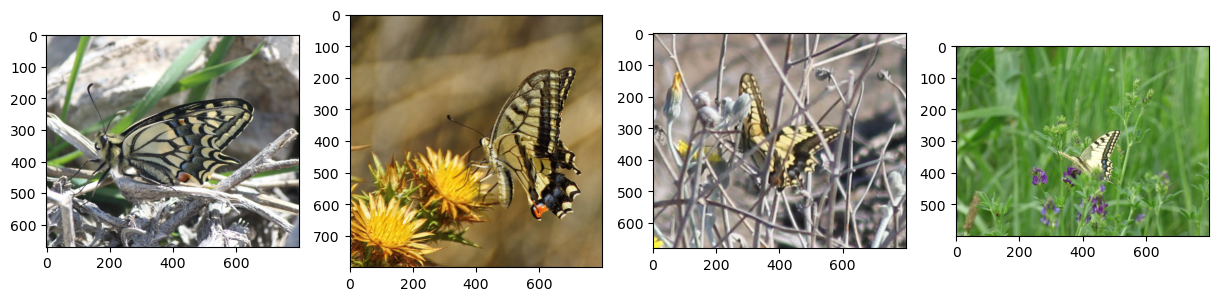

In [9]:
# Example of images for  category_id 100

img_names = df_train_file_cat[df_train_file_cat['category_id']=='100']['file_name'][:4]

plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread("input/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(1, 4, i)
    plt.imshow(img)
    i += 1
plt.show()

### Settings

In [10]:
nb_classes = 1010
batch_size = 64
img_size = 80
nb_epochs = 18

###  Input data generator -> validation split, img resizing, ...

In [11]:
# Image Data Generator 
ImageFlow = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # rescaling factor

# Fit the data to Image Data Generator
train_dataset = ImageFlow.flow_from_dataframe(dataframe=df_train_file_cat, 
                                              directory="data/input", 
                                              x_col="file_name", 
                                              y_col="category_id", 
                                              #subset="training", 
                                              batch_size=batch_size, 
                                              seed=42, 
                                              shuffle=True, 
                                              class_mode="categorical", 
                                              target_size=(img_size,img_size))  

Found 265213 validated image filenames belonging to 1010 classes.


In [12]:
valid_dataset = ImageFlow.flow_from_dataframe(dataframe=df_valid_file_cat, 
                                              directory="data/input", 
                                              x_col="file_name", 
                                              y_col="category_id", 
                                              #subset="validation", 
                                              batch_size=batch_size, 
                                              seed=42, 
                                              shuffle=True, 
                                              class_mode="categorical", 
                                              target_size=(img_size,img_size))

Found 3030 validated image filenames belonging to 1010 classes.


### Model

In [14]:
# base MobileNetV2 model 4 transfer learning
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
model.trainable = False
model_name = 'MobileNetV2'
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-20 00:13:56.468782: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-20 00:13:56.469035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 40, 40, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 40, 40, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 40, 40, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [15]:
# old way to add cutom layers
# #Adding custom layers 
# x = model.output
# x = Flatten()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# predictions = Dense(nb_classes, activation="softmax")(x)
# model_final = Model(inputs = model.input, outputs = predictions) # wrong args names were passed here -> input instead of inputs ••• output instead of outputs

# # # use old weights
# # model_final.load_weights('vgg16_1.h5')
# # compile the model -> use only once, or if want to change the optimizer/loss/metrics
# model_final.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
#Adding custom layers 
model_final = Sequential()
model_final.add(model)
model_final.add(Flatten())
model_final.add(Dense(1024, activation='relu'))
model_final.add(Dropout(0.5))
model_final.add(Dense(nb_classes, activation='softmax'))

# xception model
# model_final.compile(optimizers.RMSprop(learning_rate=0.005, decay=1e-3),loss='categorical_crossentropy',metrics=['accuracy'])
# mobilenet model V1 -> OK
model_final.compile(optimizers.Adam(learning_rate=0.0005, epsilon=1e-3,),loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
# Callbacks
checkpoint = ModelCheckpoint('data/model/mobilenet.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=False, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq="epoch")

# early = EarlyStopping(monitor='val_loss', 
#                       min_delta=0, 
#                       patience=5, 
#                       verbose=1,
#                       mode='auto')

In [18]:
model_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 3, 3, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 1024)              11797504  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1010)              1035250   
                                                                 
Total params: 15,090,738
Trainable params: 12,832,754
Non-trainable params: 2,257,984
____________________________________

### Training

In [19]:
gc.collect(); # garbage collector -> to free up memory

In [20]:
# Train the model
history = model_final.fit(train_dataset,
                          epochs=nb_epochs,
                          validation_data=valid_dataset,
                          callbacks=[checkpoint], # early is not used
                          verbose=1)

Epoch 1/18


2023-05-20 00:13:58.572633: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-20 00:13:59.684384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4144/4144 [==============================] - ETA: 0s - loss: 6.3280 - accuracy: 0.0127

2023-05-20 00:39:59.060403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to model_weight/mobilenet/V1.h5
4144/4144 [==============================] - 1580s 381ms/step - loss: 6.3280 - accuracy: 0.0127 - val_loss: 6.2036 - val_accuracy: 0.0188
Epoch 2/18
4144/4144 [==============================] - ETA: 0s - loss: 5.8841 - accuracy: 0.0236
Epoch 2: saving model to model_weight/mobilenet/V1.h5
4144/4144 [==============================] - 1575s 380ms/step - loss: 5.8841 - accuracy: 0.0236 - val_loss: 5.9573 - val_accuracy: 0.0221
Epoch 3/18
4144/4144 [==============================] - ETA: 0s - loss: 5.7339 - accuracy: 0.0286
Epoch 3: saving model to model_weight/mobilenet/V1.h5
4144/4144 [==============================] - 1575s 380ms/step - loss: 5.7339 - accuracy: 0.0286 - val_loss: 5.8969 - val_accuracy: 0.0254
Epoch 4/18
4144/4144 [==============================] - ETA: 0s - loss: 5.6495 - accuracy: 0.0321
Epoch 4: saving model to model_weight/mobilenet/V1.h5
4144/4144 [==============================] - 1578s 381ms/step - loss: 5.649

took 470 minutes for 18 epochs

<AxesSubplot:>

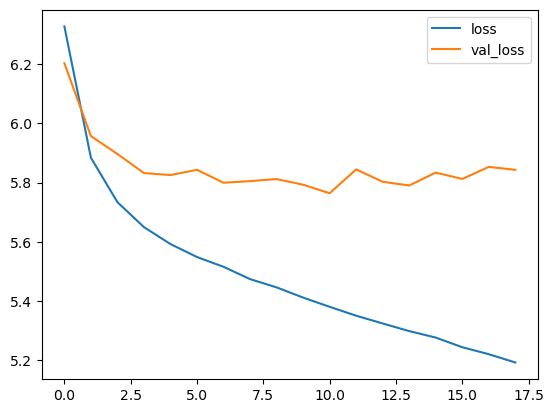

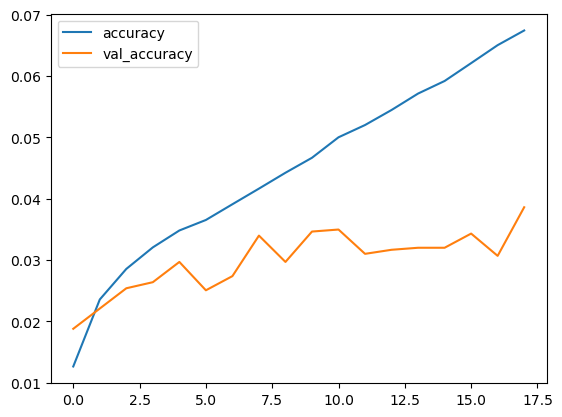

In [21]:
with open('data/model/history_mobilenetV2.json', 'w') as f:
    json.dump(history.history, f) # save history

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()


#### How to load and use weights from a checkpoint


```from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
# create model
model = Sequential()
model.add(Dense(12, input_shape=(8,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# load weights
model.load_weights("weights.best.hdf5")
#Compile model (required to make predictions)
```

### Test data

In [22]:
test_ann_file = 'input/test2019.json'
with open(test_ann_file) as data_file:
        test_anns = json.load(data_file)

In [23]:
test_img_df = pd.DataFrame(test_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
test_img_df.head()

,image_id,file_name
0,268243,test2019/e295f3c7046b1f1e80c0301401324aa9.jpg
1,268244,test2019/ad3dcbb6846ed0b4dab58d7b1a4210ba.jpg
2,268245,test2019/e697be8e296b4b140cff4f96f85c364f.jpg
3,268246,test2019/7e7ba55e6aa26ba99e814d63b15d0121.jpg
4,268247,test2019/6cb6372079d23702511c06923970f13f.jpg


In [24]:
test_dataset = ImageFlow.flow_from_dataframe(dataframe=test_img_df, 
                                              directory="input", 
                                              x_col="file_name",  
                                              batch_size = 1, 
                                              seed=42, 
                                              shuffle = False, 
                                              class_mode = None, 
                                              target_size=(img_size,img_size))

Found 35350 validated image filenames.


### Prediction

In [31]:
gc.collect();

In [32]:
predict=model_final.predict(test_dataset, 
                            steps = test_img_df.shape[0])

35350/35350 [==============================] - 452s 13ms/step


In [68]:
print('type', type(predict), 'size', predict.shape)

type <class 'numpy.ndarray'> size (35350, 1010)


In [97]:
# Show the prediction result
predictions_df = pd.DataFrame(predict)
predictions_df

,0,1,2,3,4,5,6,7,8,9,...,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009
0,5.490300e-04,1.528999e-04,7.362952e-04,0.000459,1.834402e-03,5.570955e-04,8.184074e-04,1.008282e-04,1.218003e-03,3.121847e-04,...,5.411556e-04,2.700115e-03,3.338368e-03,1.477024e-03,6.203661e-03,4.876517e-03,1.357060e-02,2.607076e-04,8.686354e-03,7.058592e-04
1,2.147499e-07,3.485784e-09,4.718887e-08,0.000001,9.960070e-08,2.885548e-09,8.771822e-09,4.112439e-09,1.175066e-07,4.325708e-10,...,1.017729e-06,1.663290e-07,2.615334e-07,1.771954e-07,6.891869e-07,2.821266e-08,1.987519e-09,1.675674e-10,3.937747e-09,4.190865e-08
2,8.453771e-07,4.132361e-08,3.669313e-07,0.001375,7.750709e-05,1.930972e-03,1.225657e-03,9.637543e-05,2.889122e-04,4.319563e-03,...,6.828099e-05,2.874507e-03,1.384573e-03,4.185773e-05,1.217668e-03,1.805288e-03,4.243744e-03,1.361715e-03,3.296982e-03,2.582741e-03
3,2.265236e-04,1.059780e-04,2.714712e-04,0.002541,1.888993e-03,5.667897e-04,7.005928e-04,6.004457e-05,5.476460e-04,4.849809e-04,...,2.730862e-04,2.673176e-03,1.583796e-03,7.717981e-04,3.275397e-03,2.792694e-03,4.262567e-03,2.612417e-04,5.928943e-03,1.354855e-03
4,4.209621e-09,1.239579e-04,6.982214e-08,0.001505,2.285806e-07,6.667525e-07,8.870144e-07,1.680196e-08,1.723391e-07,1.109379e-08,...,7.305945e-08,2.031740e-04,8.427039e-06,2.438939e-07,3.304442e-05,1.417357e-05,1.035653e-05,8.067759e-09,4.905300e-07,2.080329e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35345,1.706401e-07,1.660287e-09,3.501827e-08,0.003873,1.665507e-06,1.195305e-04,7.542863e-05,3.237960e-05,3.389052e-05,2.350374e-04,...,5.467668e-05,2.987464e-03,1.265541e-03,1.762358e-05,9.311036e-04,2.029668e-03,2.024478e-04,2.710850e-04,4.386767e-04,4.796674e-04
35346,2.647100e-12,3.918017e-07,1.435148e-09,0.000019,5.573132e-10,2.259208e-07,3.639124e-06,1.171260e-03,9.975523e-08,1.115635e-03,...,1.990918e-03,1.793644e-02,1.204262e-02,2.837131e-03,1.830224e-02,1.778177e-02,3.955591e-07,2.916826e-04,1.073522e-05,2.064693e-07
35347,5.321216e-10,5.684763e-06,2.421500e-08,0.000067,3.798409e-09,1.036353e-10,1.012572e-07,3.037813e-06,1.095216e-08,5.954162e-06,...,4.020746e-08,7.338776e-06,1.485637e-04,3.763424e-05,4.722116e-05,6.366215e-05,8.948465e-08,7.853002e-07,2.157000e-07,7.071153e-08
35348,5.915993e-05,4.539734e-06,3.369388e-05,0.001809,1.057519e-05,3.710487e-10,9.278701e-08,6.385171e-12,2.111640e-07,6.620945e-10,...,8.728236e-10,4.461162e-06,4.229272e-05,2.166952e-04,4.351931e-04,4.167310e-05,5.048181e-05,1.843057e-10,1.672083e-04,1.738830e-06


In [98]:
# pick top prediction and put into dataframe
top_predict_df = pd.DataFrame()
top_predict_df['predicted'] = predictions_df.idxmax(axis=1)

# pick the top 5 predictions for each image
top_5_pred = np.argsort(-predict, axis=1)[:,:5]
top_5_pred_df = pd.DataFrame(top_5_pred, columns=['predicted_1', 'predicted_2', 'predicted_3', 'predicted_4','predicted_5'])
top_5_pred_df

,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5
0,455,532,464,989,460
1,254,257,260,137,262
2,337,336,541,371,537
3,580,1008,335,76,102
4,485,724,748,271,520
...,...,...,...,...,...
35345,753,502,759,538,386
35346,643,1004,1001,1005,264
35347,184,193,183,160,158
35348,102,107,93,86,112


In [103]:
# top prediction dataframe export to csv

top_sub_df = pd.DataFrame()
top_sub_df = pd.merge(test_img_df, top_predict_df, left_index=True, right_index=True)
# cleanup
top_sub_df.drop(columns=['file_name'], inplace=True)
top_sub_df.rename(columns={'image_id':'id'}, inplace=True)
top_sub_df.head()

# export submission dataframe to csv
top_sub_df.to_csv('data/out/top_sub_mobilenetV2.csv', index=False)

In [104]:
# top 5 predictions dataframe export to csv

top_5_sub_df = pd.DataFrame()
top_5_sub_df = pd.concat([test_img_df, top_5_pred_df], axis=1)
# merge all predictions into one column
top_5_sub_df['predicted'] = top_5_sub_df['predicted_1'].astype(str)+ ' ' + top_5_sub_df['predicted_2'].astype(str)+ ' ' + top_5_sub_df['predicted_3'].astype(str)+ ' ' + top_5_sub_df['predicted_4'].astype(str) + ' ' + top_5_sub_df['predicted_5'].astype(str)
# clean up 
top_5_sub_df.drop(columns=['predicted_1', 'predicted_2', 'predicted_3', 'predicted_4', 'predicted_5'], inplace=True)
top_5_sub_df.drop(columns=['file_name'], inplace=True)
top_5_sub_df.rename(columns={'image_id':'id'}, inplace=True)
top_5_sub_df.head()

# export submission dataframe to csv
top_5_sub_df.to_csv('data/out/top_5_sub_mobilenetV2.csv', index=False)

In [80]:
kaggle_sub_sample_df = pd.read_csv('data/input/kaggle_sample_submission.csv')
kaggle_sub_sample_df.head()

,id,predicted
0,268243,842
1,268244,139
2,268245,988
3,268246,612
4,268247,468
